# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [6]:
# Imports here
import os
import torch
#require('torch')
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import helper
import fc_model
from PIL import Image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [7]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [8]:
# TODO: Define your transforms for the training, validation, and testing sets
training_data_transforms = transforms.Compose([transforms.RandomRotation(30),
                                               transforms.RandomResizedCrop(224), 
                                               transforms.RandomHorizontalFlip(), 
                                               transforms.ToTensor(), 
                                               transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

validaiton_data_transforms = transforms.Compose([transforms.Resize(256),
                                                 transforms.CenterCrop(224),
                                                 transforms.ToTensor(), 
                                                 transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

test_data_transforms = transforms.Compose([transforms.Resize(256),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(), 
                                           transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
# TODO: Load the datasets with ImageFolder
train_image_dataset = datasets.ImageFolder(train_dir, transform = training_data_transforms)
valid_image_dataset = datasets.ImageFolder(valid_dir, transform = validaiton_data_transforms)
test_image_dataset = datasets.ImageFolder(test_dir, transform = test_data_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_dataloader = torch.utils.data.DataLoader(train_image_dataset, batch_size = 32, shuffle = True)
valid_dataloader = torch.utils.data.DataLoader(valid_image_dataset, batch_size = 32, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_image_dataset, batch_size = 32, shuffle = True)

# Use GPU if it's available
# Good coding practice - do this after the transformation process
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names = train_image_dataset.classes

## The Mystery of the ImageFolder datasets
It is important we understood what ImageFolder module creates and this is indeed NOT straightforward. This is something to be further explained in order not to bleed with desperation when trying to understand PyTorch. ImageFolder creates a dictionary containing Keys (refering to the identity of each image) and values (enumerating those values) for each transformed image in their new life as a tensor.

In [9]:
#Here you have the mysterious dictionaries created when loading the datasets with ImageFolder. We have 102 different 
#classes, as we have 102 flower outputs from our last layer resulting from our Softmax function
train_dic = train_image_dataset.class_to_idx #class_to_index is just adding AN INDEX to the 102 flower classes
valid_dic = valid_image_dataset.class_to_idx #class_to_index is just adding AN INDEX to the 102 flower classes
test_dic = test_image_dataset.class_to_idx #class_to_index is just adding AN INDEX to the 102 flower classes
print(train_dic) #print the training dictionary. First entry is just an index. We should be adding the flowers value text
print(valid_dic) #print the training dictionary. First entry is just an index. We should be adding the flowers value text
print(test_dic) #print the training dictionary. First entry is just an index. We should be adding the flowers value text

{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '95': 97, '96': 98, '97': 99, '98': 100, '99'

In [10]:
train_image_dataset

Dataset ImageFolder
    Number of datapoints: 6552
    Root Location: flowers/train
    Transforms (if any): Compose(
                             RandomRotation(degrees=(-30, 30), resample=False, expand=False)
                             RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

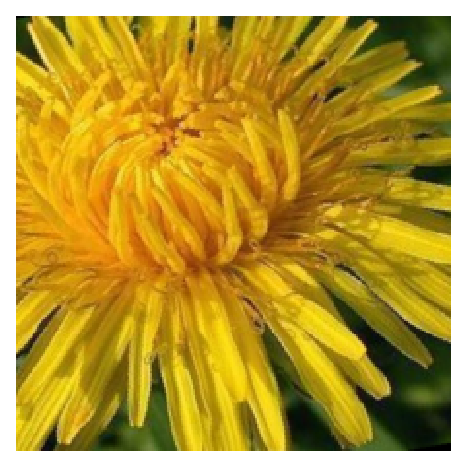

In [6]:
data_iter = iter(train_dataloader)
images, labels = next(data_iter)
helper.imshow(images[0],normalize = True);

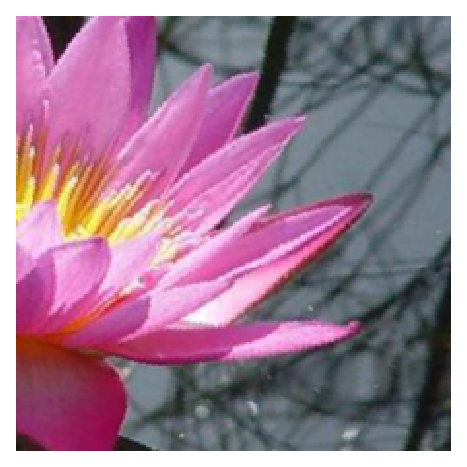

In [7]:
helper.imshow(images[1],normalize = True);

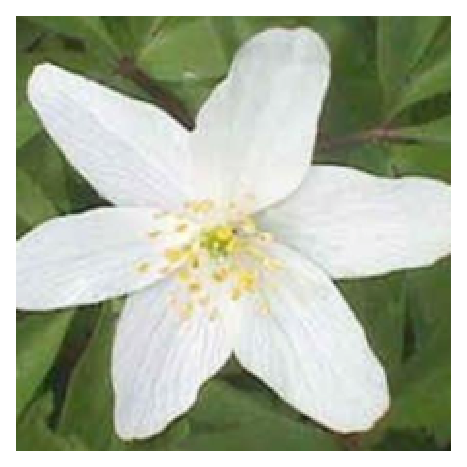

In [8]:
images, labels = next(iter(test_dataloader))
helper.imshow(images[0], normalize=True);

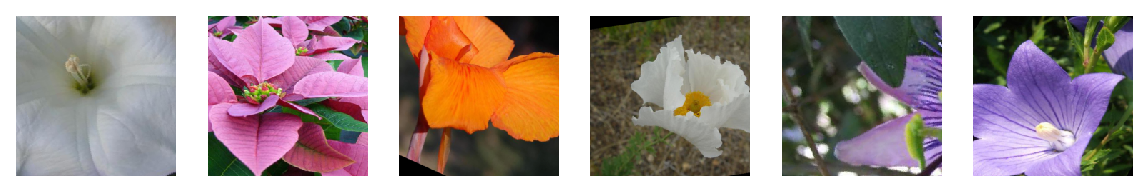

In [9]:
# show sample from the train_dataloader 
data_iter = iter(train_dataloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=6)
for pic in range(6):
    ax = axes[pic]
    helper.imshow(images[pic], ax=ax, normalize=True)

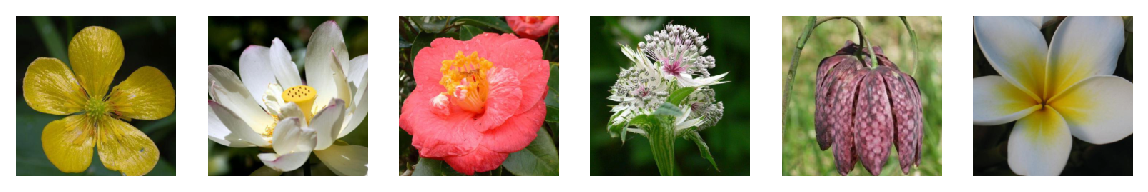

In [10]:
# show sample from the valid_dataloader 
data_iter = iter(valid_dataloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=6)
for pic in range(6):
    ax = axes[pic]
    helper.imshow(images[pic], ax=ax, normalize=True)

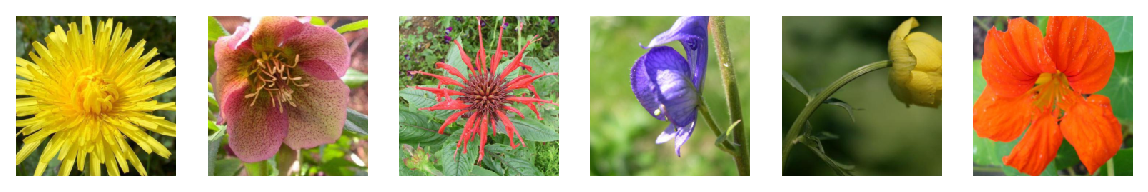

In [11]:
# show sample from the test_dataloader 
data_iter = iter(test_dataloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=6)
for pic in range(6):
    ax = axes[pic]
    helper.imshow(images[pic], ax=ax, normalize=True)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [11]:
#Our 102 flower values - THE TEXT or the NAME of those saint flowers are stored in a JSON file
#Once we read a JSON file using the code below, we can access it as we do with dictionaries and lists in Python
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [12]:
#cat_to_name is just a dictionary containing the NAMES of those 102 flowers we have been trying to classify.
#we need to attach this information to the dictionary we created above the train_dic - which is the same as the value_dic
# and the test_dic
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

In [13]:
print(type(cat_to_name))

<class 'dict'>


In [14]:
flo_dict={}
for key,value in train_dic.items():
    flo_dict[key]=[value, cat_to_name[key]]

In [15]:
flo_dict

{'1': [0, 'pink primrose'],
 '10': [1, 'globe thistle'],
 '100': [2, 'blanket flower'],
 '101': [3, 'trumpet creeper'],
 '102': [4, 'blackberry lily'],
 '11': [5, 'snapdragon'],
 '12': [6, "colt's foot"],
 '13': [7, 'king protea'],
 '14': [8, 'spear thistle'],
 '15': [9, 'yellow iris'],
 '16': [10, 'globe-flower'],
 '17': [11, 'purple coneflower'],
 '18': [12, 'peruvian lily'],
 '19': [13, 'balloon flower'],
 '2': [14, 'hard-leaved pocket orchid'],
 '20': [15, 'giant white arum lily'],
 '21': [16, 'fire lily'],
 '22': [17, 'pincushion flower'],
 '23': [18, 'fritillary'],
 '24': [19, 'red ginger'],
 '25': [20, 'grape hyacinth'],
 '26': [21, 'corn poppy'],
 '27': [22, 'prince of wales feathers'],
 '28': [23, 'stemless gentian'],
 '29': [24, 'artichoke'],
 '3': [25, 'canterbury bells'],
 '30': [26, 'sweet william'],
 '31': [27, 'carnation'],
 '32': [28, 'garden phlox'],
 '33': [29, 'love in the mist'],
 '34': [30, 'mexican aster'],
 '35': [31, 'alpine sea holly'],
 '36': [32, 'ruby-lipped

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [16]:
model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 104991887.29it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [17]:
#Set default tensor type, then move model and data to GPU
torch.set_default_tensor_type('torch.FloatTensor')

In [18]:
# TODO: Build and train your network
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [19]:
# TODO: Build and train your network
#Define our new classifier which we will be training
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(25088, 1500)),
                            ('relu', nn.ReLU()),
                            ('dropout',nn.Dropout(.2)),
                            ('fc2', nn.Linear(1500,102)),
                            ('output', nn.LogSoftmax(dim=1))
                            ]))

In [20]:
# TODO: Build and train your network
#We have created our classifier, now let's attach this to our model
model.classifier = classifier

In [21]:
# TODO: Build and train your network
#let's check our model now is the way we want it, thus the last classifier for the CNN VGG network is the way we defined it
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [22]:
# TODO: Build and train your network
#Here I define my loss
#Since our last laye is LogSoftmax we use Negative Log Likelihood loss function NLLLoss()
criterion = nn.NLLLoss()

In [23]:
# TODO: Build and train your network
#Here I defime my optimizer
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

In [24]:
# TODO: Build and train your network
#move the model to whichever device we have available
model.to(device);

In [25]:
# TODO: Build and train your network
#Now we have the model setup so we are ready to train it

#Define global variables we will be using during the training
epochs = 5 
steps = 0 #we will track the number of trainsteps we do so we set this to zero
print_every = 50
for epoch in range(epochs):
    #Define local variables we will be using during the training
    training_loss = 0 #we wil track the training loss we do so we set this to zero
    for images, labels in train_dataloader: #loop into our data (images)
        steps += 1 #cumulate steps. Every time we go through one of these batches, we will increment steps here
        images, labels = images.to(device), labels.to(device)# Move input and label tensors to the default device
        optimizer.zero_grad() #Here we zero our gradients in order not to have leftover values from previous loops
        
        log_ps = model.forward(images) #get our log probabilities from our model
        
        loss = criterion(log_ps, labels) #We get the loss from the criterion
        loss.backward() #We do a backwards pass
        optimizer.step() #With the optimizer we take a step
        training_loss += loss.item() #Here we increment our training loss - This is where we keep track of our training loss
               
        ### This is where our training loop ends ###
        ### Now we drop out of our training loop to test our network's accuracy and loss on our validation dataset ###
        
        
        
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval() # this turns our model to the evaluation inference mode which turns off Dropout
            # In this way we can accurately use our network for making predictions

            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                for images, labels in valid_dataloader:
                    images, labels = images.to(device), labels.to(device)

                    output = model.forward(images)
                    #images, labels = images.to(device), labels.to(device) #transfer my tensors to the GPU
                    log_ps = model(images) #with the model we already have we will pass images from our validation dataset
                    valid_loss += criterion(log_ps, labels) #get loss from validation dataset
                
                    #calculate accuracy
                    ps = torch.exp(log_ps) #our model returns log probabilities, so to get crude probabilities we do this
                    top_p, top_class = ps.topk(1, dim=1) #here we get top probabilities and top classes using ps.topk()
                    equality = top_class == labels.view(*top_class.shape) #check for equality with our labels
                    accuracy += torch.mean(equality.type(torch.FloatTensor)) #with equality tensor we update our accuracy

            print(f"Epoch {epoch+1}/{epochs}.. "
                f"Train loss: {training_loss/print_every:.3f}.. "
                f"Valid loss: {valid_loss/len(valid_dataloader):.3f}.. "
                f"Valid accuracy: {accuracy/len(valid_dataloader):.3f}")
                
            training_loss = 0 #we set our training loss back to zero
            model.train() #we set our model in training mode - we now use the dropout

Epoch 1/5.. Train loss: 4.210.. Valid loss: 3.414.. Valid accuracy: 0.301
Epoch 1/5.. Train loss: 3.360.. Valid loss: 2.495.. Valid accuracy: 0.435
Epoch 1/5.. Train loss: 2.701.. Valid loss: 1.800.. Valid accuracy: 0.570
Epoch 1/5.. Train loss: 2.113.. Valid loss: 1.438.. Valid accuracy: 0.642
Epoch 2/5.. Train loss: 1.638.. Valid loss: 1.145.. Valid accuracy: 0.729
Epoch 2/5.. Train loss: 1.592.. Valid loss: 0.944.. Valid accuracy: 0.773
Epoch 2/5.. Train loss: 1.420.. Valid loss: 0.852.. Valid accuracy: 0.801
Epoch 2/5.. Train loss: 1.326.. Valid loss: 0.741.. Valid accuracy: 0.825
Epoch 3/5.. Train loss: 0.927.. Valid loss: 0.666.. Valid accuracy: 0.846
Epoch 3/5.. Train loss: 1.148.. Valid loss: 0.613.. Valid accuracy: 0.863
Epoch 3/5.. Train loss: 1.062.. Valid loss: 0.559.. Valid accuracy: 0.860
Epoch 3/5.. Train loss: 1.028.. Valid loss: 0.527.. Valid accuracy: 0.864
Epoch 4/5.. Train loss: 0.650.. Valid loss: 0.496.. Valid accuracy: 0.882
Epoch 4/5.. Train loss: 0.911.. Valid 

In [26]:
images.shape

torch.Size([24, 3, 224, 224])

In [27]:
images.to(device)

tensor([[[[-1.5528, -1.5528, -1.5528,  ..., -1.4672, -1.4672, -1.4843],
          [-1.5528, -1.5528, -1.5699,  ..., -1.4672, -1.4672, -1.4843],
          [-1.5528, -1.5528, -1.5699,  ..., -1.4843, -1.4672, -1.4843],
          ...,
          [-1.7240, -1.6727, -1.6727,  ..., -1.2445, -1.2445, -1.2445],
          [-1.7240, -1.6898, -1.6727,  ..., -1.2274, -1.2274, -1.2274],
          [-1.7069, -1.6898, -1.6727,  ..., -1.2445, -1.2445, -1.2445]],

         [[-1.6155, -1.5805, -1.5805,  ..., -1.5455, -1.5805, -1.5980],
          [-1.6155, -1.5980, -1.5980,  ..., -1.5630, -1.5805, -1.5980],
          [-1.6155, -1.6155, -1.5980,  ..., -1.5630, -1.5805, -1.5980],
          ...,
          [-1.6506, -1.5980, -1.5980,  ..., -1.2479, -1.2479, -1.2479],
          [-1.6506, -1.6155, -1.5980,  ..., -1.2304, -1.2304, -1.2304],
          [-1.6331, -1.6155, -1.5980,  ..., -1.2479, -1.2479, -1.2479]],

         [[-1.5430, -1.5256, -1.5256,  ..., -1.5256, -1.5604, -1.5779],
          [-1.5430, -1.5430, -

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [28]:
# TODO: Do validation on the test set
test_loss = 0
accuracy = 0
print_every = 50
model.eval() # this turns our model to the evaluation inference mode which turns off Dropout
            # In this way we can accurately use our network for making predictions
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device) #transfer my tensors to the GPU
        log_ps = model(images) #with the model we already have we will pass images from our validation dataset
        test_loss += criterion(log_ps, labels) #get loss from validation dataset
                
        #calculate accuracy
        ps = torch.exp(log_ps) #our model returns log probabilities, so to get crude probabilities we do this
        top_p, top_class = ps.topk(1, dim=1) #here we get top probabilities and top classes using ps.topk()
        equality = top_class == labels.view(*top_class.shape) #check for equality with our labels
        accuracy += torch.mean(equality.type(torch.FloatTensor)) #with equality tensor we update our accuracy
                

        print(f"Train loss: {test_loss/print_every:.3f}.. "
                f"Test loss: {test_loss/len(test_dataloader):.3f}.. "
                f"Test accuracy: {accuracy/len(test_dataloader):.3f}")

Train loss: 0.011.. Test loss: 0.021.. Test accuracy: 0.029
Train loss: 0.016.. Test loss: 0.031.. Test accuracy: 0.064
Train loss: 0.029.. Test loss: 0.056.. Test accuracy: 0.093
Train loss: 0.039.. Test loss: 0.075.. Test accuracy: 0.126
Train loss: 0.050.. Test loss: 0.096.. Test accuracy: 0.159
Train loss: 0.063.. Test loss: 0.120.. Test accuracy: 0.192
Train loss: 0.076.. Test loss: 0.147.. Test accuracy: 0.226
Train loss: 0.082.. Test loss: 0.158.. Test accuracy: 0.260
Train loss: 0.090.. Test loss: 0.174.. Test accuracy: 0.294
Train loss: 0.101.. Test loss: 0.195.. Test accuracy: 0.326
Train loss: 0.111.. Test loss: 0.213.. Test accuracy: 0.361
Train loss: 0.118.. Test loss: 0.227.. Test accuracy: 0.397
Train loss: 0.128.. Test loss: 0.247.. Test accuracy: 0.430
Train loss: 0.140.. Test loss: 0.270.. Test accuracy: 0.460
Train loss: 0.158.. Test loss: 0.303.. Test accuracy: 0.492
Train loss: 0.169.. Test loss: 0.325.. Test accuracy: 0.525
Train loss: 0.184.. Test loss: 0.354.. T

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [29]:
# TODO: Save the checkpoint 
#Now that we have our network trained, we can save it to a file, what's called the state_dict
#state_dict is a dictionary that contains all the parameters for our model - all weights and bias tensors.

#print out our model
print("Our model: \n\n", model, "\n")
print("The state dict keys: \n\n", model.state_dict().keys(), "\n")

Our model: 

 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [30]:
#attach the dictionary train_dic to the model as an attribute which makes inference easier later on
model.class_to_idx = train_dic

In [31]:
#save the state_dict() with torch.save to a checkpoint.pth
#model_ft, train_losses = train_model(model, criterion, optimizer, exp_num_epocs = 15)
model = model.to('cpu')
checkpoint = {'structure' : 'vgg16',
              'input_size' : 25088,
              'hidden_layers': 1500,
              'output_size': 102, 
              'classifier': model.classifier,
              'weights_bias_tensors' : model.state_dict(),
              'class_index' : train_image_dataset.class_to_idx,
              'epochs' : 5,
              'state_optimizer': optimizer.state_dict(),
              'classes': model.class_to_idx}

torch.save(checkpoint,'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [32]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filename):
    
    #load the checkpoint
    checkpoint = torch.load(filename)
        
    #I use the arch key of the checkpoint
    #to initialize the correct pre-trained model
    model = getattr(models, checkpoint['structure'])  
    
    #After initializing the correct pre-trainned model
    # I freeze parameters as usual
    for param in model.parameters():
            param.requires_grad = False

    #I can now replace the classifier
    model.classifier = checkpoint['classifier']        
            
    #I can now load the weights
    model.load_state_dict(checkpoint['weights_bias_tensors'])
    
    #Last but not least I do this thing that I clearly do not understand what it is doing
    model.class_to_idx = checkpoint['classes']
    
    
    return model


In [34]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img_pil = Image.open(image)   
    adjustments = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img_tensor = adjustments(img_pil)

    return img_tensor

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [35]:
import numpy as np
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

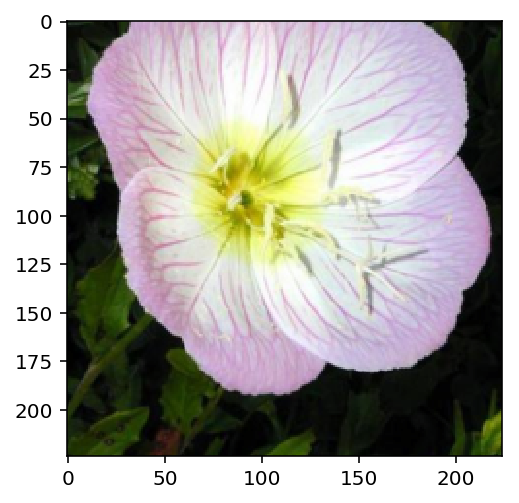

In [36]:
image_output = process_image("flowers/test/1/image_06743.jpg")
imshow(image_output)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [37]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
   
    with torch.no_grad():
        image = process_image(image_path)
        
        
        #The model requires a 4-D tensor:
        #1. first dimension specifying the images in a batch, 
        #2. second dimension specifying the number of color channels 
        #3. third dimension image width
        #4. fourth dimension immage height 
        #we should add the batch dimension for the image tensor. 
        #we use image = image.unsqueeze(0) This will add one more dimension at index 0.
        image = image.unsqueeze(0)
        #image = image.unsqueeze_(0) #unsqueeze with replacement
        
        image = image.float()
        image = image.to(device)
        logps = model.forward(image)       
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(5, dim=1)
        top_p = top_p.tolist()[0]
        top_class = top_class.tolist()[0]
        
        idx_to_class = {model.class_to_idx[i]: i for i in model.class_to_idx}
        labels = []
    for c in top_class:
        labels.append(cat_to_name[idx_to_class[c]])

    return top_p, labels


In [38]:
probs, labels = predict('flowers/test/54/image_05402.jpg', model)
print(probs)
print(labels)        

[0.9975615739822388, 0.001667609205469489, 0.00021398288663476706, 0.00019467630772851408, 0.0001527446147520095]
['sunflower', 'barbeton daisy', 'blanket flower', 'english marigold', 'common dandelion']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

flowers/test/1/image_06743.jpg
[0.7141690254211426, 0.20169609785079956, 0.018079817295074463, 0.01679769717156887, 0.01664573885500431]
['pink primrose', 'hibiscus', 'balloon flower', 'petunia', 'tree mallow']
5


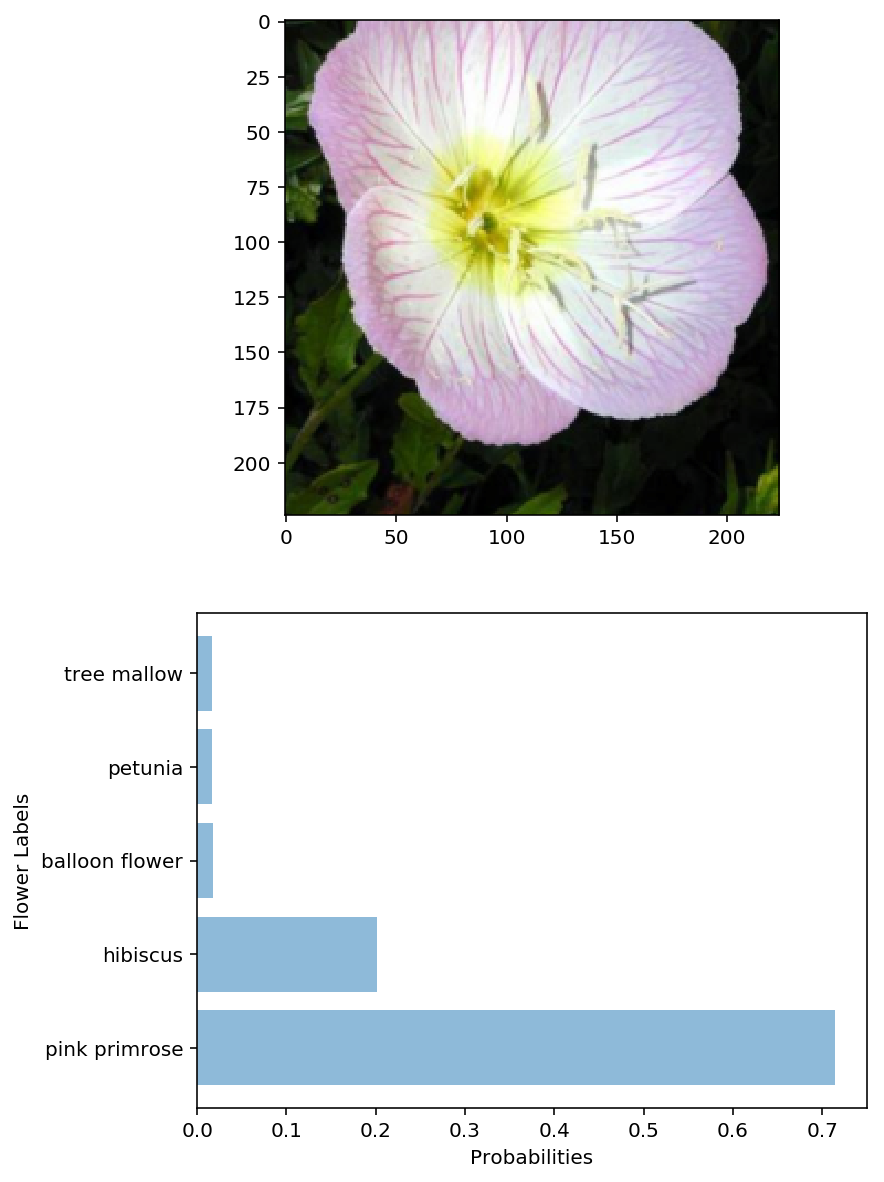

In [56]:
fig = plt.figure(figsize = (6,10));

#First visulization
ax1 = fig.add_subplot(2, 1, 1) # two rows, one column, first plot
#Display + process image
image = os.path.join('flowers', 'test', '1', 'image_06743.jpg')
print(image)
result = process_image(image)
ax1 = imshow(result, ax1);

ax2 = fig.add_subplot(2, 1, 2) # two rows, one column, second plot
probs, classes = predict(image, model)
print(probs)
print(classes)  
print(len(classes))
# Get range for probabilities
y_range = np.arange(len(classes)) #we need to distribute 

# Plot as a horizontal bar graph
plt.barh(y_range, probs, align='center', alpha=0.5)
plt.yticks(y_range, classes)
plt.ylabel('Flower Labels')
plt.xlabel('Probabilities')
plt.show()